In [4]:
import polars as pl 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pl.read_csv("movie.csv")
df

text,label
str,i64
"""I grew up (b. 1965) watching a…",0
"""When I put this movie in my DV…",0
"""Why do people who do not know …",0
"""Even though I have great inter…",0
"""Im a die hard Dads Army fan an…",1
…,…
"""""Western Union"" is something o…",1
"""This movie is an incredible pi…",1
"""My wife and I watched this mov…",0


In [6]:
label_count = df.group_by('label').agg([
    pl.col('label').count().alias('count')
])
label_count

label,count
i64,u32
0,20019
1,19981


<Axes: xlabel='label', ylabel='count'>

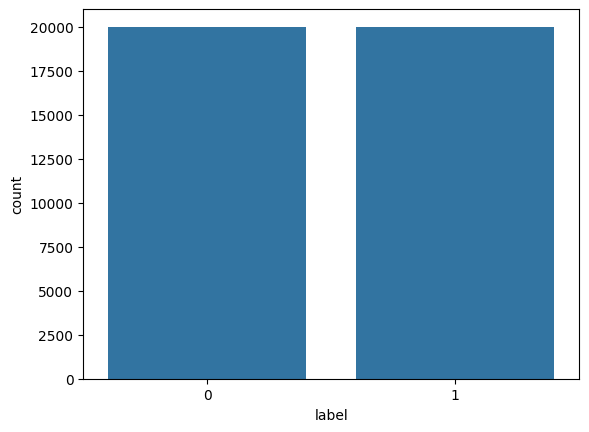

In [7]:
import seaborn as sns
sns.barplot(label_count,x="label",y="count")

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
import nltk

# Function to remove stopwords from a given text
def remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    
    stop_words = set(stopwords.words('english'))
    new_words = word_tokenize(text)
    new_filtered_words = [word for word in new_words if word.lower() not in stop_words]
    # Join the filtered words to form a clean text
    new_clean_text = ' '.join(new_filtered_words)
    return new_clean_text

# Function to remove punctuation from a given text
def remove_punctuation(text):
    if not isinstance(text, str):
        return ""
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return ' '.join(tokens)

# Function to clean a column by removing punctuation and stopwords
def cleaning(column):
    return column.map_elements(remove_punctuation, return_dtype=pl.Utf8).map_elements(remove_stopwords, return_dtype=pl.Utf8)


In [9]:
df = df.with_columns(cleaning(pl.col('text')).alias('Clean_text'))

In [10]:
df = df.with_columns(pl.col("Clean_text").map_elements(lambda x: len(x.split()),return_dtype=pl.Int64).alias("word_count"))
df

text,label,Clean_text,word_count
str,i64,str,i64
"""I grew up (b. 1965) watching a…",0,"""grew b 1965 watching loving Th…",87
"""When I put this movie in my DV…",0,"""put movie DVD player sat coke …",163
"""Why do people who do not know …",0,"""people know particular time pa…",96
"""Even though I have great inter…",0,"""Even though great interest Bib…",33
"""Im a die hard Dads Army fan an…",1,"""Im die hard Dads Army fan noth…",106
…,…,…,…
"""""Western Union"" is something o…",1,"""Western Union something forgot…",302
"""This movie is an incredible pi…",1,"""movie incredible piece work ex…",27
"""My wife and I watched this mov…",0,"""wife watched movie plan visit …",103


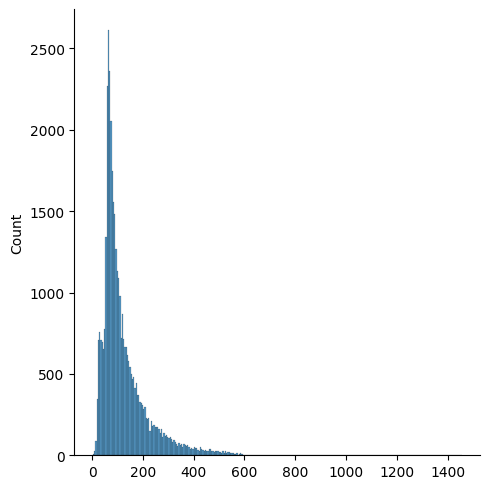

In [11]:
sns.displot(df["word_count"])

In [12]:
pos = " ".join(df["Clean_text"].filter(df["label"]==1))
neg = " ".join(df["Clean_text"].filter(df["label"]==0))

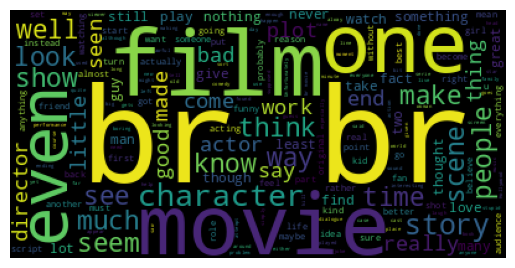

In [13]:
from wordcloud import WordCloud

neg_cloud = WordCloud(background_color='black').generate(neg)
plt.imshow(neg_cloud)
plt.axis(False)
plt.show()

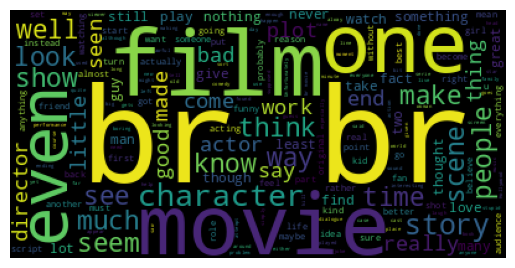

In [14]:
pos_cloud = WordCloud(background_color='black').generate(pos)
plt.imshow(neg_cloud)
plt.axis(False)
plt.show()

In [15]:
import subprocess
import re
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
def preprocess_data(text):
    stopwords_set = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stopwords_set)
    
    lemma = WordNetLemmatizer()
    text = ' '.join(lemma.lemmatize(word) for word in text.split())
    
    text = ' '.join(word for word in text.split() if len(word) > 2)
    return text

In [17]:
df = df.with_columns(pl.col('Clean_text').map_elements(clean_text, return_dtype=pl.Utf8).alias('Clean_text'))
df = df.with_columns(pl.col('Clean_text').map_elements(preprocess_data, return_dtype=pl.Utf8).alias('Clean_text'))

Model Training

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [20]:
tfidf = TfidfVectorizer(lowercase=False)

X = tfidf.fit_transform(df['text'])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

<40000x118017 sparse matrix of type '<class 'numpy.float64'>'
	with 5664222 stored elements in Compressed Sparse Row format>

In [34]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report
model = ComplementNB()
model.fit(X_train, y_train)

ComplementNB()

In [35]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.866
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      3966
           1       0.89      0.84      0.86      4034

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



In [36]:
def predict_sentiment(comment, model, tfidf):
    comment_list = [comment]
    comment_vector = tfidf.transform(comment_list)
    comment_prediction = model.predict(comment_vector)[0]
    
    if comment_prediction == 1:
        print("Positive comment")
    else:
        print("Negative comment")

# Clean and preprocess the comment
clean_comment = clean_text('The dialogue was cringeworthy and cliché-ridden. It"s as if the scriptwriter had never heard human beings speak before')
preprocess_comment = preprocess_data(clean_comment)

# Predict sentiment
predict_sentiment(preprocess_comment, model, tfidf)

Negative comment


In [39]:
import pickle
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as tfidf_file:
    pickle.dump(tfidf, tfidf_file)